In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score

def load_data(filepath):
    _, file_extension = os.path.splitext(filepath)
    
    if file_extension == '.csv':
        df = pd.read_csv(filepath)
        samples = df['your_column_name'].values
    elif file_extension == '.dat':
        #Looks like DAT is binary encoded added a b in r as rb
        with open(filepath, 'rb') as f:
            samples = f.readlines()
        samples = np.array([sample.strip() for sample in samples])
    else:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    return samples

def count_lines(filepath):
    with open(filepath, 'rb') as f:
        return sum(1 for _ in f)
    
class CSVDataGenerator:
    def __init__(self, file_pattern, batch_size, sequence_length, max_samples=None, for_training=True):     
        self.file_pattern = file_pattern
        self.file_list = sorted(glob.glob(self.file_pattern))
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.current_file_idx = 0
        self.dataframe_iterator = None
        self.labels_iterator = None
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0

    def _load_next_file(self):
        if self.current_file_idx >= len(self.file_list):
            print("No more files to process.")
            raise StopIteration

        current_file = self.file_list[self.current_file_idx]
        df = pd.read_csv(current_file)

        # Filter out rows where 'IQ Data' is '0j'
        df['IQ Data'] = df['IQ Data'].apply(lambda x: complex(x.replace('i', 'j')))
        df = df[df['IQ Data'] != 0j]

        # Check if DataFrame is empty or 'IQ Data' column is missing
        if df.empty or 'IQ Data' not in df.columns:
            raise ValueError(f"File {current_file} is empty or missing 'IQ Data' column after filtering 0j.")

        # If not for training, extract the labels
        if not self.for_training and 'label' in df.columns:
            self.labels_iterator = iter(df['label'].map(lambda x: 1 if x == 'jammer' else 0).values)
        else:
            self.labels_iterator = None

        print(f"Processing file: {current_file}")
        self.dataframe_iterator = iter(df['IQ Data'].values)
        self.current_file_idx += 1

    # Reset function to be used when switching from training to prediction
    def reset_for_prediction(self):
        self.current_file_idx = 0
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self.dataframe_iterator = None
        self._load_next_file()  # Start from the first file again

    def __iter__(self):
        self.current_file_idx = 0
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self._load_next_file()
        return self

    def process_data(self, samples):
        real_parts = np.real(samples)
        imag_parts = np.imag(samples)

        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        X = np.array(list(zip(real_parts, imag_parts))).reshape(-1, self.sequence_length, 2)
        return X

    def __next__(self):
        if self.max_samples and self.total_samples_processed >= self.max_samples:
            raise StopIteration("Reached max_samples limit.")

        while len(self.samples_buffer) < self.batch_size * self.sequence_length:
            try:
                chunk = next(self.dataframe_iterator)
                self.samples_buffer.append(chunk)
                if not self.for_training and self.labels_iterator is not None:
                    label_chunk = next(self.labels_iterator)
                    self.labels_buffer.append(label_chunk)
            except StopIteration:
                if self.current_file_idx >= len(self.file_list):
                    raise StopIteration("No more data to process.")
                self._load_next_file()

        samples = self.samples_buffer[:self.batch_size * self.sequence_length]
        self.samples_buffer = self.samples_buffer[self.batch_size * self.sequence_length:]

        X_chunk = self.process_data(np.array(samples))

        if not self.for_training:
            labels = self.labels_buffer[:self.batch_size * self.sequence_length]
            self.labels_buffer = self.labels_buffer[self.batch_size * self.sequence_length:]
            return X_chunk, np.array(labels)
        else:
            return X_chunk, X_chunk
    def close(self):
        self.samples_buffer = []
        self.labels_buffer = []
        self.total_samples_processed = 0
        self.current_file_idx = 0
        self.dataframe_iterator = None
        self.labels_iterator = None   

#------------------------------------------------------------------------------------------------------
def mec_kocaoglu_np(p, q):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions.
    """
    p = tf.cast(p, tf.float64) / tf.reduce_sum(p)
    q = tf.cast(q, tf.float64) / tf.reduce_sum(q)
    J = tf.zeros((tf.size(q), tf.size(p)), dtype=tf.float64)
    M = tf.stack([p, q], axis=0)
    r = tf.reduce_min(tf.reduce_max(M, axis=1))

    def body(r, M, J):
        print("r before update:", r)
        print("M before update:", M)
        print("J before update:", J)
        a_i = tf.argmax(M, axis=1)
        r_updated = tf.reduce_min(tf.reduce_max(M, axis=1))
        update_values = tf.stack([r, r])
        a_i = tf.cast(a_i, dtype=tf.int32)
        indices_range = tf.range(tf.size(a_i), dtype=tf.int32)
        indices = tf.stack([indices_range, a_i], axis=1)
        M_updates = tf.scatter_nd(indices, -update_values, tf.shape(M))
        M = M + M_updates
        J_updates = tf.scatter_nd(indices, [r, r], tf.shape(J))
        #J = J + J_updates
        J = J_updates
        print("r after update:", r_updated)
        print("M after update:", M)
        print("J after update:", J)
        return r_updated, M, J

    def condition(r, M, J):
        return r > 0
    r, M, J = tf.while_loop(condition, body, loop_vars=[r, M, J])
    print("r after the loop update:", r)
    print("M after the loop update:", M)
    print("J after the loop update:", J)
    return J

from tensorflow.keras.layers import Layer

class MECTransformationLayer(Layer):
    def __init__(self, num_bins=50, latent_dim=25, **kwargs):
        super(MECTransformationLayer, self).__init__(**kwargs)
        self.num_bins = num_bins
        self.latent_dim = latent_dim

    def call(self, inputs):
        z_mean, z = inputs
        z_mean = tf.cast(z_mean, dtype=tf.float64)
        z = tf.cast(z, dtype=tf.float64)

        def process_pair(pair):
            z_mean_sample, z_sample = pair

            # Apply MEC using the provided mec_kocaoglu_np function
            mec_transformed = mec_kocaoglu_np(z_mean_sample, z_sample)
            transformed_pair = tf.reshape(mec_transformed, [-1])

            # Adjust size to exactly match the latent dimension
            current_size = tf.size(transformed_pair)
            return tf.cond(
                current_size > self.latent_dim,
                true_fn=lambda: transformed_pair[:self.latent_dim],
                false_fn=lambda: tf.pad(transformed_pair, [[0, self.latent_dim - current_size]], constant_values=0)
            )

        # Use tf.map_fn to apply process_pair function across batches
        transformed_batch = tf.map_fn(process_pair, (z_mean, z), dtype=tf.float64, parallel_iterations=10)
        return transformed_batch

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.latent_dim)


def process_latent_variables(z_mean, z):
    z_transformed = apply_mec_to_data(z_mean, z)
    #print('Output of MEC transformation shape:', z_transformed.shape)
    return z_transformed
#self Attention LSTM Autoencoder Model
class SelfAttentionLayer(Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttentionLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, inputs):
        return self.multi_head_attention(inputs, inputs, inputs)
# Variational Autoencoder (VAE) Class
class VAE:
    def __init__(self, sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim,
                 epsilon_std=0.1, dropout_rate=0.2):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.original_dim = original_dim
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.epsilon_std = epsilon_std
        self.dropout_rate = dropout_rate
        self.encoder = None
        self.decoder = None
        self.vae = None
        self._build()
        #self._build2()

    def _sampling3(self, args):
        z_mean, _ = args  # Ignore z_log_var for simplicity
        z_mean_transformed = process_latent_variables(z_mean)
        epsilon_std = 0.05  # Use a fixed small std deviation to reduce variability
        #epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=epsilon_std)
        epsilon = K.random_normal(shape=K.shape(z_mean_transformed), mean=0., stddev=epsilon_std)
        #epsilon = process_latent_variables(epsilon)
        #tf.print('epsilon_value:', epsilon)
        epsilon = tf.cast(epsilon, 'float64')     
        return z_mean_transformed + epsilon
    def _sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output
    def new_sampling_method(self, args):
        z_mean, _ = args  # Ignore z_log_var for simplicity
        # Generate a new distribution based on z_mean with modified entropy characteristics
        z_transformed = tf.nn.softmax(z_mean)  # Example transformation using softmax to model a different distribution approach
        epsilon_std = 0.1
        epsilon = K.random_normal(shape=K.shape(z_transformed), mean=0., stddev=epsilon_std)
        return z_transformed + epsilon
    def _sampling33(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=self.epsilon_std)
        # Standard reparameterization trick
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        # Consider z_mean as x and z as y for MEC application
        #z_mec = apply_mec_to_data(z_mean, z)
        #z_mec = process_latent_variables(z_mean, z)
        return z
    def calculate_z_input(self, inputs, z_mean):
        # Calculate mean and variance of input
        input_mean = K.mean(inputs, axis=[1, 2], keepdims=True)
        input_var = K.var(inputs, axis=[1, 2], keepdims=True)
        print('input_mean shape:', input_mean.shape)

        # Reshape input_mean and input_var
        input_mean = tf.squeeze(input_mean, axis=1)
        input_var = tf.squeeze(input_var, axis=1)
        
        # Print the shapes to verify
        print("input_mean_reshaped shape:", input_mean.shape)
        print("input_var_reshaped shape:", input_var.shape)
        input_std_dev = K.sqrt(input_var)
        print('input_std_dev shape:', input_std_dev.shape)

        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=0.1)
        print('epsilon shape:', epsilon.shape)

        z_input = input_mean + input_std_dev * epsilon
        return z_input
        
    def _build(self):
        # Encoder
        #model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 8), 
                       #return_sequences=True)
        inputs = Input(shape=(self.sequence_length, self.feature_dim), name='encoder_input')
        print('inputs', inputs)
        #x = Bidirectional(LSTM(self.intermediate_dim, activation='tanh', return_sequences=True))(inputs)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(inputs)
        #x = Dropout(self.dropout_rate)(x)
        #self_attention = SelfAttentionLayer(num_heads=2, key_dim=self.original_dim)  # Adjust num_heads and key_dim as needed
        #x = self_attention(x)
        x = LSTM(self.intermediate_dim, activation='softmax', return_sequences=False)(x)
        #x = Dropout(self.dropout_rate)(x)
        print('X before latent', x)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        
        z_input = self.calculate_z_input(inputs, z_mean)

        #z = Lambda(self._sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        #z = Lambda(self._sampling3, output_shape=(self.latent_dim,))([z_mean, z_mean])
        z = Lambda(self._sampling33, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        #z = apply_mec_to_data(z_input, z)

        mec_layer = MECTransformationLayer(latent_dim=self.latent_dim)
        z = mec_layer([z_input, z]) 
        
        # Initiate Encoder
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')        
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = RepeatVector(self.sequence_length)(latent_inputs)
        x = LSTM(self.intermediate_dim, activation='tanh', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        x = LSTM(self.original_dim, activation='tanh', return_sequences=True)(x)
        #x = Dropout(self.dropout_rate)(x)
        final_activation = 'sigmoid' #'linear' if data is not normalized
        #outputs = TimeDistributed(Dense(self.original_dim, activation=final_activation))(x)
        outputs = TimeDistributed(Dense(self.feature_dim))(x)
        # Instantiate the decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        # VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')

    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        xent_loss = mse
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    def simplified_vae_loss(self, x, x_decoded_mean, z_mean):
        mse = tf.reduce_mean(tf.square(x - x_decoded_mean), axis=(1, 2))
        mean_loss = tf.reduce_mean(tf.square(z_mean))
        total_loss = mse + mean_loss
        return K.mean(total_loss)
    
    def compile(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        def vae_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=vae_loss_wrapper)

    def compile2(self, learning_rate=0.0005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)

        # Define a wrapper function for the custom loss
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, z_log_var, _ = self.encoder(x)
            return self.custom_loss(x, x_decoded_mean, z_mean, z_log_var)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_custom(self, learning_rate=0.001, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        def custom_loss_wrapper(x, x_decoded_mean):
            z_mean, _, _ = self.encoder(x)
            return self.simplified_vae_loss(x, x_decoded_mean, z_mean)

        self.vae.compile(optimizer=optimizer, loss=custom_loss_wrapper)
    def compile_simple_autoencoder(self, learning_rate=0.005, optimizer='adam'):
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        
        # Simple reconstruction loss
        self.vae.compile(optimizer=optimizer, loss='mse')

# Instantiate and Compile the VAE
sequence_length = 10
feature_dim = 2
original_dim = 50
intermediate_dim = 50
latent_dim = 25

vae_model = VAE(sequence_length, feature_dim, original_dim, intermediate_dim, latent_dim)
#vae_model.vae.compile(optimizer='adam', loss=vae_model.vae_loss)
#vae_model.compile2(learning_rate=0.005)
vae_model.compile_simple_autoencoder(learning_rate=0.005)
#vae_model.compile_custom(learning_rate=0.005)

# Model Training
batch_size = 40
max_train_samples = 10000
train_steps = max_train_samples // (batch_size * sequence_length)
max_samples = 10000  # Maximum samples to read (or None to read all)
max_test_samples = 10000

#1000-100
pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
#1000-1000
# pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/data-bunch-3/pure_data/pure_iq_samples_*.csv'
# mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/data-bunch-3/mixed_data/mixed_iq_samples_*.csv'

# pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
# mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
# pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
# mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'
# Example file patterns
#pure_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\pure_data\\pure_iq_samples_*.csv'
#mixed_file_pattern = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\mixed_data\\mixed_iq_samples_*.csv'

# pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/data-bunch-3/pure_data/pure_iq_samples_*.csv'
# mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/data-bunch-3/mixed_data/mixed_iq_samples_*.csv'

#Data Generator Instances
train_gen_instance = CSVDataGenerator(pure_file_pattern, batch_size, sequence_length, 
                                      max_train_samples, for_training=True)
combined_gen_instance = CSVDataGenerator(mixed_file_pattern, batch_size, sequence_length, 
                                         max_test_samples, for_training=False)
# train_gen_instance = DataGenerator(pure_file_new,batch_size=batch_size, sequence_length=sequence_length, 
#                                    max_samples=max_train_samples, for_training=True)
# combined_gen_instance = DataGenerator(mixed_file_new,batch_size=batch_size, sequence_length=sequence_length, 
#                                       for_training=False)
collected_z_means = []
collected_z_log_var= []
collected_z_inputs = [] 
collected_z_sampled_vae = []
num_epochs = 1  # You can adjust the number of epochs as needed
steps_per_epoch = train_steps  # Assuming one epoch processes all the data
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    #train_gen_instance.reset()  # Reset the generator at the beginning of each epoch
    train_gen_instance.__iter__() 
    for step in range(steps_per_epoch):
        try:
            X_chunk, Y_chunk = next(train_gen_instance)
        except StopIteration:
            #train_gen_instance.reset()  # Reset the generator when it runs out of data
            train_gen_instance.__iter__() 
            X_chunk, Y_chunk = next(train_gen_instance)
        if epoch < 1:
            if step < 1:
                print('epoch for d-collection:', epoch)
                print('step for d-collection:', step)
                z_mean, z_log_var, z_input = vae_model.encoder(X_chunk)
                collected_z_means.append(z_mean.numpy())
                collected_z_log_var.append(z_log_var.numpy())
                collected_z_inputs.append(z_input.numpy()) 

        #loss = model.train_on_batch(X_chunk, Y_chunk)
        loss = vae_model.vae.train_on_batch(X_chunk, Y_chunk)
        #print(f"Step {step + 1}/{steps_per_epoch}", end='\r')
        if step % 100 == 0:
            print(f"Step {step + 1}/{train_steps}, Loss: {loss}")
    print()

num_predictions = 60  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")

combined_gen_instance.reset_for_prediction()
predicted_labels = []
true_labels = []
reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
accuracies = []
try:    
    for i in range(num_predictions):
        print(f'Prediction number: {i}')
        X_chunk_test, current_labels = next(combined_gen_instance)
        print(f'Shape of X_chunk_test: {X_chunk_test.shape}')       

        X_chunk_pred = vae_model.vae.predict(X_chunk_test)
        chunk_errors = np.mean(np.square(X_chunk_test - X_chunk_pred), axis=1)
        print(f'Shape of chunk_errors: {chunk_errors.shape}')
        
        max_error_per_sequence = chunk_errors.max(axis=1)
        print(f'Size of max_error_per_sequence: {max_error_per_sequence.size}')
        
        # Check if max_error_per_sequence is empty
        if max_error_per_sequence.size == 0:
            print("max_error_per_sequence is empty, skipping this batch.")
            continue
        error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)

        if error_per_sequence.size > 0:
            threshold1 = np.percentile(error_per_sequence, 95)
            print(f'Threshold1: {threshold1}')
        else:
            print("error_per_sequence is empty, skipping percentile calculation.")
            continue
        intrusion_detected_inloop = error_per_sequence > threshold1
        #print(f'y_true type: {type(current_labels)}, shape: {current_labels.shape}')
        #print(f'y_pred type: {type(intrusion_detected_inloop)}, shape: {intrusion_detected_inloop.shape}')
        #print(f'y_true type: {type(current_labels[:len(error_per_sequence)])}, shape: {current_labels[:len(error_per_sequence)].shape}')
        batch_accuracy = accuracy_score(current_labels[:len(error_per_sequence)], intrusion_detected_inloop)
        print('batch_accuracy:', batch_accuracy)
        accuracies.append(batch_accuracy)

        # Append to respective lists
        true_labels.extend(current_labels[:len(error_per_sequence)])       
        predicted_labels.extend(intrusion_detected_inloop)
        
        reconstruction_errors.extend(chunk_errors)        
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)
except StopIteration:
    print("All samples processed.")




2024-05-08 17:55:12.378653: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 17:55:12.379756: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 17:55:12.403753: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 17:55:12.404173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 17:55:12.789317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

inputs KerasTensor(type_spec=TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name='encoder_input'), name='encoder_input', description="created by layer 'encoder_input'")
X before latent KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='lstm_1/strided_slice_3:0', description="created by layer 'lstm_1'")
input_mean shape: (None, 1, 1)
input_mean_reshaped shape: (None, 1)
input_var_reshaped shape: (None, 1)
input_std_dev shape: (None, 1)
epsilon shape: (None, 25)


2024-05-08 17:55:13.797541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 17:55:13.799177: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Instructions for updating:
Use fn_output_signature instead
r before update: Tensor("mec_transformation_layer/map/while/while/Placeholder:0", shape=(), dtype=float64)
M before update: Tensor("mec_transformation_layer/map/while/while/Placeholder_1:0", shape=(2, 25), dtype=float64)
J before update: Tensor("mec_transformation_layer/map/while/while/Placeholder_2:0", shape=(25, 25), dtype=float64)
r after update: Tensor("mec_transformation_layer/map/while/while/Min:0", shape=(), dtype=float64)
M after update: Tensor("mec_transformation_layer/map/while/while/add:0", shape=(2, 25), dtype=float64)
J after update: Tensor("mec_transformation_layer/map/while/while/ScatterNd_1:0", shape=(25, 25), dtype=float64)
r after the loop update: Tensor("mec_transformation_layer/map/while/while:2", shape=(), dtype=float64)
M after the loop update: Tensor("mec_transformation_layer/map/while/while:3", shape=(2, 25), dtype=float64)
J after the loop update: Tensor("mec_transformation_layer/map/while/while:4", sha

r after update: tf.Tensor(0.024492700218437986, shape=(), dtype=float64)
M after update: tf.Tensor(
[[ 1.78523999e-02  1.88016689e-02  1.43398220e-02  1.06925184e-02
  -3.40825553e-04 -3.63149744e-03 -9.09814047e-03 -7.02309696e-04
  -1.40134485e-03 -1.85070789e-04 -1.13080001e-03 -9.67876840e-04
   0.00000000e+00 -1.55231629e-03  9.97095024e-03 -2.98688091e-04
  -2.35044745e-03 -2.42509641e-03 -5.35502537e-04 -1.10992400e-03
  -4.78768666e-03 -6.28117654e-03  2.21763884e-02 -1.00707249e-02
  -1.29106468e-03]
 [ 8.21215181e-02 -3.51998948e-03 -3.21264643e-01 -1.93832468e-01
   1.81430928e-02  9.06619123e-02  9.79945760e-02 -3.88099364e-03
   1.23320763e-01  1.31868411e-01  1.27265575e-03  1.03459948e-01
  -2.28950030e-02 -6.80703683e-02  1.12413099e-01  7.45743984e-02
  -1.57840499e-01 -3.21003341e-01 -3.21125600e-02  8.67434668e-02
  -3.62956664e-02  1.10006846e-01 -4.06102987e-02  1.00252280e-01
   1.14166119e-01]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.       

r before update: tf.Tensor(0.08445772756885196, shape=(), dtype=float64)
M before update: tf.Tensor(
[[ 6.66544324e-02  8.06125794e-02  1.07279525e-02  2.62772835e-02
   3.74241170e-02  4.09488214e-02  8.44577276e-02 -2.49934634e-03
   1.89722297e-02  4.63279052e-02  7.91948805e-02  8.22237618e-03
   6.19084274e-02  5.12338359e-02 -1.47361740e-02  5.64234845e-02
   6.41096710e-02  4.02864865e-02 -3.71689669e-03  6.64454817e-02
   2.64075198e-02  4.30477473e-02  3.53443298e-02  3.38285911e-02
   4.20965365e-02]
 [ 1.19536442e+01  4.90602840e+00 -1.78007416e+01 -3.00284048e+00
   2.75395782e+00  8.13266465e+00  1.56781940e+01 -6.66378476e+00
  -1.83186146e+01  7.44618146e+00 -4.67400956e+00  6.47880916e+00
  -1.95913556e-02  2.16671738e+00 -2.69583458e+00 -7.90019773e+00
   6.86512903e+00 -7.89728787e-01 -6.46716437e+00  1.36660361e+01
  -3.61152674e-01 -9.31509213e+00 -1.01145340e+01  3.09950760e+00
   5.97641676e+00]], shape=(2, 25), dtype=float64)
J before update: tf.Tensor(
[[0. 0. 0

r after update: tf.Tensor(0.010727952541360644, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-1.25404480e-02 -3.84514821e-03 -8.24427717e-03 -1.30236295e-04
  -2.86236945e-03 -1.14771516e-03  0.00000000e+00 -2.49934634e-03
  -7.30505379e-03 -4.90593071e-03 -1.41769890e-03  8.22237618e-03
  -2.20124357e-03 -5.18964859e-03 -1.47361740e-02 -5.48494288e-03
  -2.33581075e-03 -6.62334896e-04 -3.71689669e-03 -2.08950727e-04
  -7.42107131e-03 -3.28015788e-03 -2.07978720e-03 -1.51573874e-03
  -9.51210783e-04]
 [ 1.19536442e+01  4.90602840e+00 -1.78007416e+01 -3.00284048e+00
   2.75395782e+00  8.13266465e+00  1.45917342e+01 -6.66378476e+00
  -1.83186146e+01  7.44618146e+00 -4.67400956e+00  6.47880916e+00
  -1.95913556e-02  2.16671738e+00 -2.69583458e+00 -7.90019773e+00
   6.86512903e+00 -7.89728787e-01 -6.46716437e+00  1.36660361e+01
  -3.61152674e-01 -9.31509213e+00 -1.01145340e+01  3.09950760e+00
   5.97641676e+00]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.       

r before update: tf.Tensor(0.07608873482158031, shape=(), dtype=float64)
M before update: tf.Tensor(
[[ 5.24379503e-03  1.15853334e-02  5.31933704e-02  3.64252736e-02
  -3.31680848e-02 -1.07824687e-02  1.80031839e-02  5.55852556e-02
  -3.93156893e-03  4.89563410e-02  1.07961141e-03  4.07084597e-02
   5.00330903e-02  4.37538583e-02  1.15413657e-02  7.56245496e-02
   5.25672697e-02  1.38759585e-02  1.86232160e-02  5.83652578e-02
   5.16792336e-02  3.44697636e-02 -1.06931712e-02  0.00000000e+00
   7.08640258e-02]
 [-2.46829555e+00 -4.27787534e-01  1.49426835e+00  5.31223489e-01
  -1.44587787e+00 -1.13686882e-01  3.60320092e-01 -8.20470481e-01
  -8.30872744e-01  1.54380243e+00  1.08553909e+00 -5.25344026e-02
   1.62924684e+00 -2.92812670e+00 -2.25083146e-01  6.55719141e-01
   5.54465822e-02 -3.35475234e-02  1.72302857e+00 -5.10651853e-01
   8.74605691e-01  1.56013790e+00  6.37523135e-01 -1.45326735e+00
  -1.47056366e-01]], shape=(2, 25), dtype=float64)
J before update: tf.Tensor(
[[0.     

r after update: tf.Tensor(0.0, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-6.29757067e-03 -2.29062510e-03 -2.39188521e-03 -4.28318612e-03
  -3.31680848e-02 -1.07824687e-02 -6.20032015e-04 -2.78000216e-03
  -3.93156893e-03 -1.07674931e-03 -4.16418363e-03 -3.04539852e-03
  -1.64614331e-03 -5.20248271e-03 -4.39677182e-05 -4.64185256e-04
  -6.26100732e-04 -4.12722541e-03 -1.58465476e-02 -1.24987680e-02
  -8.88036074e-04 -1.95551005e-03 -1.06931712e-02 -1.07961141e-03
  -4.76052380e-03]
 [-2.46829555e+00 -4.27787534e-01  1.42505320e+00  5.31223489e-01
  -1.44587787e+00 -1.13686882e-01  3.60320092e-01 -8.20470481e-01
  -8.30872744e-01  1.42620011e+00  1.08553909e+00 -5.25344026e-02
   1.42499178e+00 -2.92812670e+00 -2.25083146e-01  6.55719141e-01
   5.54465822e-02 -3.35475234e-02  1.42484552e+00 -5.10651853e-01
   8.74605691e-01  1.42112654e+00  6.37523135e-01 -1.45326735e+00
  -1.47056366e-01]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.         0.         0.  

r after update: tf.Tensor(0.0729124800746144, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-6.37919674e-02 -1.19453267e-01 -2.27567726e-02 -6.46980494e-02
  -5.42374724e-02 -6.89890223e-03 -2.13788847e-02 -4.72266348e-02
  -3.24413691e-02 -4.92352234e-02  3.41862039e-02 -7.54290739e-03
   2.62573685e-02  4.41939893e-02  6.62162500e-02  6.88184140e-02
   0.00000000e+00  5.73703481e-02  3.61494988e-02 -1.24800419e-02
  -3.48174229e-03 -3.05755547e-03 -9.01857792e-04  2.34306131e-02
  -1.03618463e-01]
 [ 3.84961019e-03 -4.48441017e-01 -4.05535628e-02  1.08182196e-01
   9.92213105e-02  4.11495032e-02  9.03717451e-02  5.77469570e-02
   9.38470382e-02 -3.66442050e-02  4.56480150e-02  7.06586943e-02
  -2.25165780e-02 -3.39998499e-04  2.81821771e-03 -4.23720625e-01
  -1.08632558e-01  6.73556060e-02  8.66741386e-02  2.20533168e-02
   1.15043573e-01  1.32872079e-01 -3.50917251e-02 -1.89655015e-01
   1.15248576e-02]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.         

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



r after update: tf.Tensor(0.10127618073543829, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-0.03335954 -0.03912285 -0.0041321  -0.0023746   0.09037589 -0.06962712
   0.03977867  0.07725653  0.01468491 -0.08766696 -0.08053766 -0.00262339
   0.02665226 -0.07331322 -0.00498896  0.06069767  0.07528095  0.00945704
  -0.01388642  0.         -0.04805334 -0.01428316  0.05196982  0.0893024
   0.08028572]
 [ 0.01769111  0.08715801 -0.03127143 -0.03023775  0.0558351   0.01419102
   0.08643089  0.0137289   0.02711319 -0.00847324  0.09852189 -0.05789382
  -0.04836064  0.00061629  0.03397809 -0.0661123  -0.03328238  0.09424851
   0.07721983 -0.00048185  0.00406331  0.06295834  0.01894547 -0.07915847
  -0.19565554]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.         0.         0.10974942 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.    

r after update: tf.Tensor(0.04338905996023762, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-0.02407689 -0.00180088  0.03263665  0.01366004 -0.00246781  0.01134129
   0.02094546  0.03260107  0.03487053  0.00202763 -0.00713315  0.
   0.02153989 -0.00289426 -0.0048305  -0.00491803  0.03540809 -0.00353908
   0.04112475 -0.00172605 -0.00297242 -0.00106091 -0.00737923 -0.00903846
   0.02841644]
 [ 0.00942618  0.1665952  -0.04036791  0.06896437  0.13468164 -0.30846029
   0.13323712  0.15521386  0.05567091  0.08876147 -0.25437739 -0.06655258
   0.16626125  0.18178257 -0.22975668  0.11321417 -0.16969205  0.0089604
   0.16223023  0.11089468  0.14407594 -0.0712536   0.0600371  -0.24734208
  -0.17147034]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.0

r after update: tf.Tensor(0.02094546105394599, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-2.40768917e-02 -1.80088116e-03 -2.23388173e-03  1.36600388e-02
  -2.46780647e-03  1.13412884e-02 -5.94431080e-04 -3.55789568e-05
  -5.37563153e-04  2.02762599e-03 -7.13314757e-03  0.00000000e+00
  -6.87654359e-03 -2.89425878e-03 -4.83050440e-03 -4.91802819e-03
  -5.71666134e-03 -3.53907619e-03 -2.26430588e-03 -1.72605394e-03
  -2.97241885e-03 -1.06091250e-03 -7.37922927e-03 -9.03845800e-03
  -4.18463318e-03]
 [ 9.42617957e-03  1.25470449e-01 -4.03679106e-02  6.89643656e-02
   1.13141752e-01 -3.08460288e-01  1.33237118e-01  1.22577216e-01
   5.56709090e-02  8.87614712e-02 -2.54377395e-01 -6.65525825e-02
   1.30853156e-01  1.09977073e-01 -2.29756682e-01  1.13214168e-01
  -1.69692052e-01  8.96040483e-03  1.27359704e-01  1.10894680e-01
   1.11474870e-01 -7.12535982e-02  6.00371033e-02 -2.47342081e-01
  -1.71470343e-01]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.        

r after update: tf.Tensor(0.031946396010332584, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-1.49766954e-03 -1.12592777e-03 -1.63675270e-03  1.45522213e-02
  -1.64089946e-03 -1.46017091e-03 -2.41624594e-03 -5.77942003e-03
  -4.47372374e-04  2.79273670e-02 -4.16753457e-03 -7.38105637e-05
   3.18077973e-02 -5.12407183e-04 -8.19525263e-04  3.06581801e-02
  -3.23106887e-03  0.00000000e+00  2.14090591e-02 -1.08263790e-03
  -3.82666461e-04  1.34674278e-02 -8.11562860e-03 -1.47484902e-03
  -1.31394981e-03]
 [ 3.43355251e-01  2.92352762e-01  4.41078975e-01 -7.83168848e-01
  -5.80267672e-01  3.98160163e-01  2.08172143e-02 -2.91525410e-01
  -4.38166252e-02 -1.60450828e-02  4.40891752e-01  5.60968456e-03
   8.57506014e-02  4.38978632e-01 -3.53608741e-01  2.31404408e-02
   6.10767005e-02 -5.72585363e-01 -9.28372172e-02  4.43954538e-01
   5.41824606e-02 -1.92118757e-01 -8.97555286e-02  4.39055836e-01
  -3.70032251e-01]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.       

r after the loop update: tf.Tensor(0.0, shape=(), dtype=float64)
M after the loop update: tf.Tensor(
[[-1.49766954e-03 -1.12592777e-03 -1.63675270e-03 -6.85683781e-03
  -1.64089946e-03 -1.46017091e-03 -2.41624594e-03 -5.77942003e-03
  -4.47372374e-04 -2.73081308e-03 -4.16753457e-03 -7.38105637e-05
  -1.38598701e-04 -5.12407183e-04 -8.19525263e-04 -1.14961720e-03
  -3.23106887e-03 -1.34674278e-02 -6.51830791e-03 -1.08263790e-03
  -3.82666461e-04 -1.08479350e-03 -8.11562860e-03 -1.47484902e-03
  -1.31394981e-03]
 [ 3.43355251e-01  2.92352762e-01  4.09271178e-01 -7.83168848e-01
  -5.80267672e-01  3.98160163e-01  2.08172143e-02 -2.91525410e-01
  -4.38166252e-02 -1.60450828e-02  4.10233572e-01  5.60968456e-03
   8.57506014e-02  4.03017352e-01 -3.53608741e-01  2.31404408e-02
   6.10767005e-02 -5.72585363e-01 -9.28372172e-02  3.98540714e-01
   5.41824606e-02 -1.92118757e-01 -8.97555286e-02  4.11128469e-01
  -3.70032251e-01]], shape=(2, 25), dtype=float64)
J after the loop update: tf.Tensor(
[

r before update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while/Placeholder:0", shape=(), dtype=float64)
M before update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while/Placeholder_1:0", shape=(2, 25), dtype=float64)
J before update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while/Placeholder_2:0", shape=(25, 25), dtype=float64)
r after update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while/Min:0", shape=(), dtype=float64)
M after update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while/add:0", shape=(2, 25), dtype=float64)
J after update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while/ScatterNd_1:0", shape=(25, 25), dtype=float64)
r after the loop update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while:2", shape=(), dtype=float64)
M after the loop update: Tensor("vae_mlp/encoder/mec_transformation_layer/map/while/while:3", shape=(2, 25), dtype=float64)
J after the 

2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 3.377069178991664
batch_accuracy: 0.75
Prediction number: 22
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.5010009527027266
batch_accuracy: 0.75
Prediction number: 23
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.3102118741660138
batch_accuracy: 0.75
Prediction number: 24
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 2.863955645353179
batch_accuracy: 0.75
Prediction number: 25
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_erro

2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.3914417462911206
batch_accuracy: 0.75
Prediction number: 59
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.7297590948588135
batch_accuracy: 0.75
Prediction number: 60
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 2.6105671710231855
batch_accuracy: 0.75
Prediction number: 61
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.8120856720810208
batch_accuracy: 0.75
Prediction number: 62
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 6ms/step
Shape of chunk_errors: (40, 2)
Size of max_er

2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 4.2922333402871224
batch_accuracy: 0.75
Prediction number: 96
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 3.9112111673281467
batch_accuracy: 0.25
Prediction number: 97
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 2.0556566633916105
batch_accuracy: 0.75
Prediction number: 98
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 2.583059296974557
batch_accuracy: 0.75
Prediction number: 99
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_err

2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 2.4395549454748484
batch_accuracy: 0.75
Prediction number: 132
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.414652094943596
batch_accuracy: 0.75
Prediction number: 133
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.452306258601082
batch_accuracy: 0.75
Prediction number: 134
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 2.599316061605176
batch_accuracy: 0.75
Prediction number: 135
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_e

2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 3.883322443452969
batch_accuracy: 0.75
Prediction number: 168
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.304235922430142
batch_accuracy: 0.75
Prediction number: 169
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 1.365698201689444
batch_accuracy: 0.75
Prediction number: 170
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_error_per_sequence: 40
Threshold1: 3.7271051347266377
batch_accuracy: 0.75
Prediction number: 171
Shape of X_chunk_test: (40, 10, 2)
2/2 [==============================] - 0s 5ms/step
Shape of chunk_errors: (40, 2)
Size of max_e

threshold1: 2.650846533941837
threshold percentile: 2.1335826274894694
len(is_intrusion_detected): 800
num_total_sequences: 7800
        Part  True Count  False Count
0       Real         588         7412
1  Imaginary         598         7402
2    Overall        1186        14814
Number of jamming sequences detected: 1186 out of 16000 sequences
Length of true labels: 800
Length of predicted labels: 800
Confusion Matrix:
[[546 182]
 [ 54  18]]
ROC AUC: 0.5
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       728
           1       0.09      0.25      0.13        72

    accuracy                           0.70       800
   macro avg       0.50      0.50      0.48       800
weighted avg       0.84      0.70      0.76       800



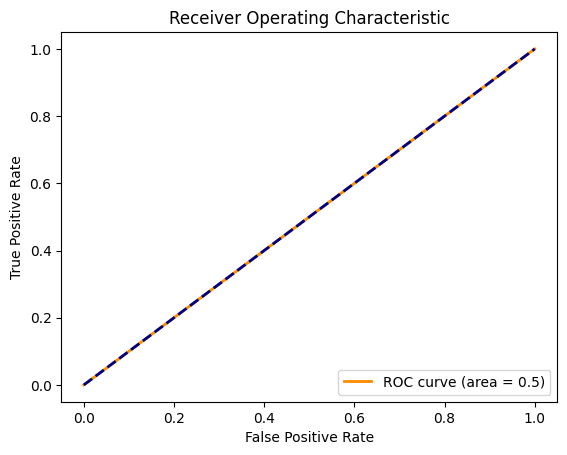

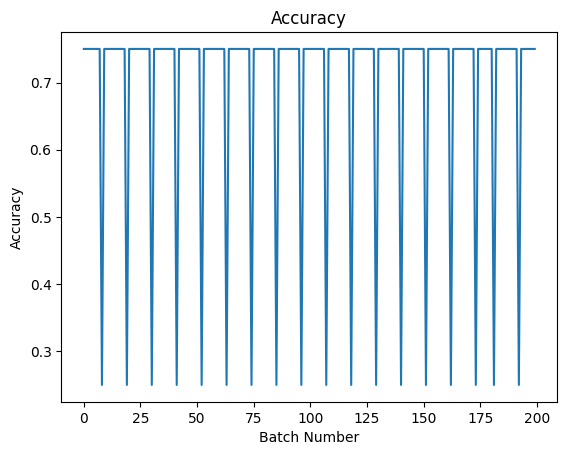

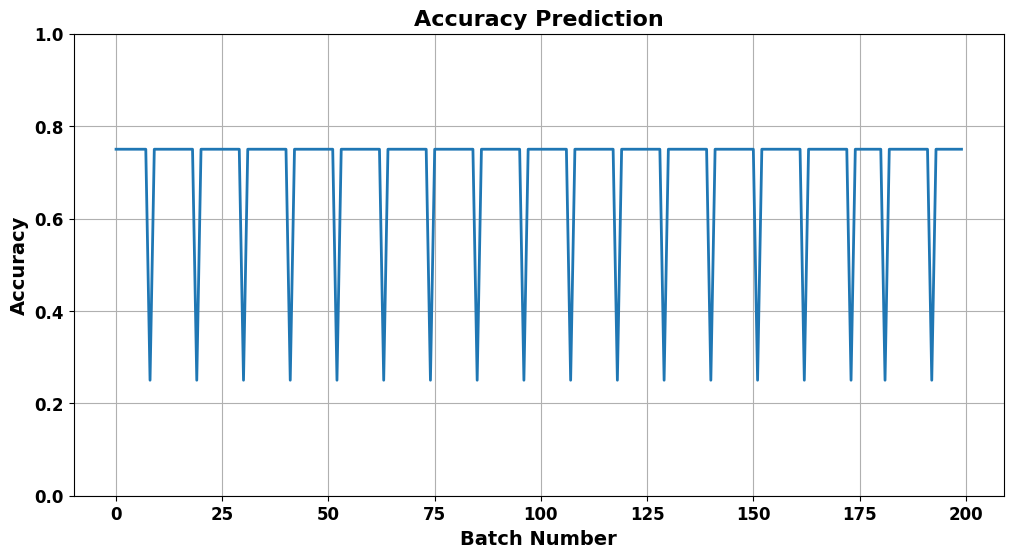

In [2]:
def plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path):
    for idx in range(0, len(all_X_chunk_test), sequence_length):
        sequence_idx = idx // sequence_length
        if all_intrusion_flags[sequence_idx]:
            plt.figure(figsize=(14, 6))
            time_steps = np.arange(idx * sequence_length, (idx + 1) * sequence_length)

            real_part_test = all_X_chunk_test[idx, :, 0].reshape(-1)
            imag_part_test = all_X_chunk_test[idx, :, 1].reshape(-1)
            real_part_pred = all_X_chunk_pred[idx, :, 0].reshape(-1)
            imag_part_pred = all_X_chunk_pred[idx, :, 1].reshape(-1)

            plt.plot(time_steps, real_part_test, 'b-', label='Original Real', linewidth=2)
            plt.plot(time_steps, real_part_pred, 'r--', label='Reconstructed Real', linewidth=2)
            plt.plot(time_steps, imag_part_test, 'g-', label='Original Imag', linewidth=2)
            plt.plot(time_steps, imag_part_pred, 'y--', label='Reconstructed Imag', linewidth=2)
            
            # Define where the fill should be applied (assuming the entire range for this example)
            where_fill = np.full_like(time_steps, True, dtype=bool)  # Fill the entire range
            plt.fill_between(time_steps, -3, 3, where=where_fill, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')

            #plt.fill_between(time_steps, -3, 3, where=True, color=(1, 0.5, 0.5), alpha=0.3, label='Intrusion Detected')
            
            # Enhancing font size and making bold
            plt.title(f'Original vs Reconstructed with Intrusion (Sequence {sequence_idx})', fontsize=18, fontweight='bold')
            plt.xlabel('Sample Index', fontsize=16, fontweight='bold')
            plt.ylabel('IQ Sample', fontsize=16, fontweight='bold')
            plt.legend(loc='lower right', fontsize=15)

            # Enhancing xtick and ytick labels
            for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
                label.set_fontsize(13)
                label.set_fontweight('bold')

            plt.tight_layout()

            filename = os.path.join(save_path, f'intrusion_sequence_{sequence_idx}.png')
            plt.savefig(filename)
            plt.close()


#---------------------------------------111-----------------------------------
reconstruction_error = np.array(reconstruction_errors)

max_error_per_sequence = reconstruction_error.reshape(-1, 2).max(axis=1)  # Shape (num_predictions * batch_size * sequence_length,)
error_per_sequence = max_error_per_sequence.reshape(-1, sequence_length).mean(axis=1)  # Shape (num_predictions * batch_size,)
# Determine the threshold for intrusion
threshold1 = np.percentile(error_per_sequence, 90)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 90)
print('threshold percentile:', threshold2)

is_intrusion_detected = error_per_sequence > threshold1 
num_total_sequences = num_predictions * batch_size - num_predictions
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('num_total_sequences:', num_total_sequences)
#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)
#print('all_X_chunk_test.shape:', all_X_chunk_test.shape)
#print('all_X_chunk_pred.shape:', all_X_chunk_pred.shape)
all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)
#save_path = '/home/mreza/5G accelerator/ID_MEC/ID_MEC_VA/tested/trained/detected_plots'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)
#---------------------------------------------------------------------------
#jamming_detected = reconstruction_error > threshold2
jamming_detected = reconstruction_error > threshold1
train_gen_instance.close()
combined_gen_instance.close()
#Table to get insight
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")


true_labels = np.array(true_labels).flatten()
predicted_labels = np.array(predicted_labels, dtype=int).flatten()
#predicted_labels = np.array(reconstruction_errors > threshold2, dtype=int).flatten()

# Verify lengths and shapes
print("Length of true labels:", len(true_labels))
print("Length of predicted labels:", len(predicted_labels))


try:
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"ROC AUC: {roc_auc}")
    print(report)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("Error in calculating metrics:", e)

#accuracy
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12, 6))  # Increase the size of the plot
plt.plot(accuracies, linewidth=2)  # Increase line width for better visibility
plt.title('Accuracy Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Batch Number', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
# Increase font size and bold x-axis and y-axis values
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 (as accuracy ranges between 0 and 1)
plt.grid(True)  # Add grid for better readability
plt.show()

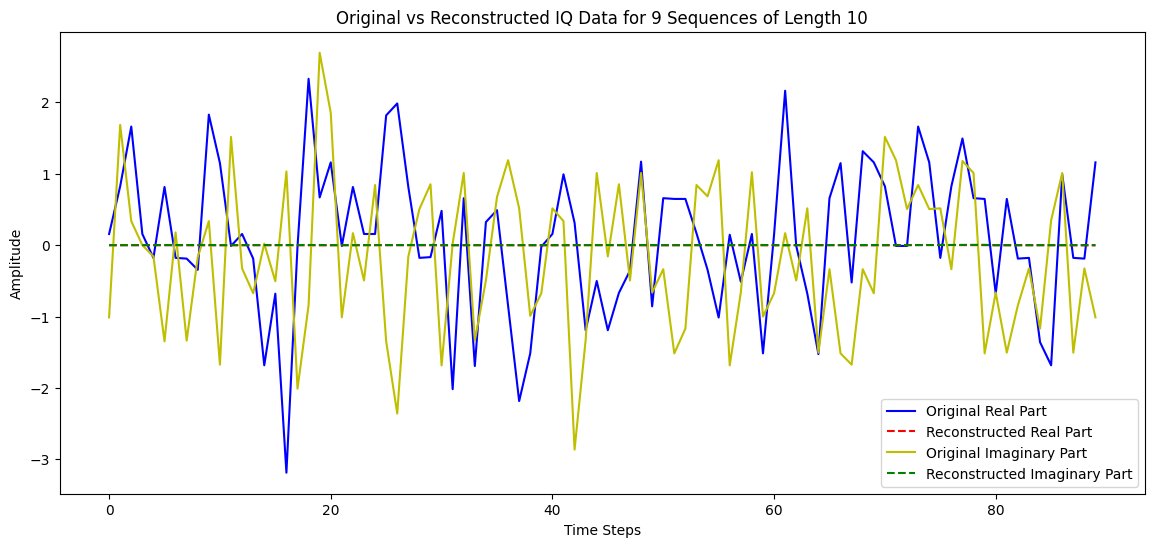

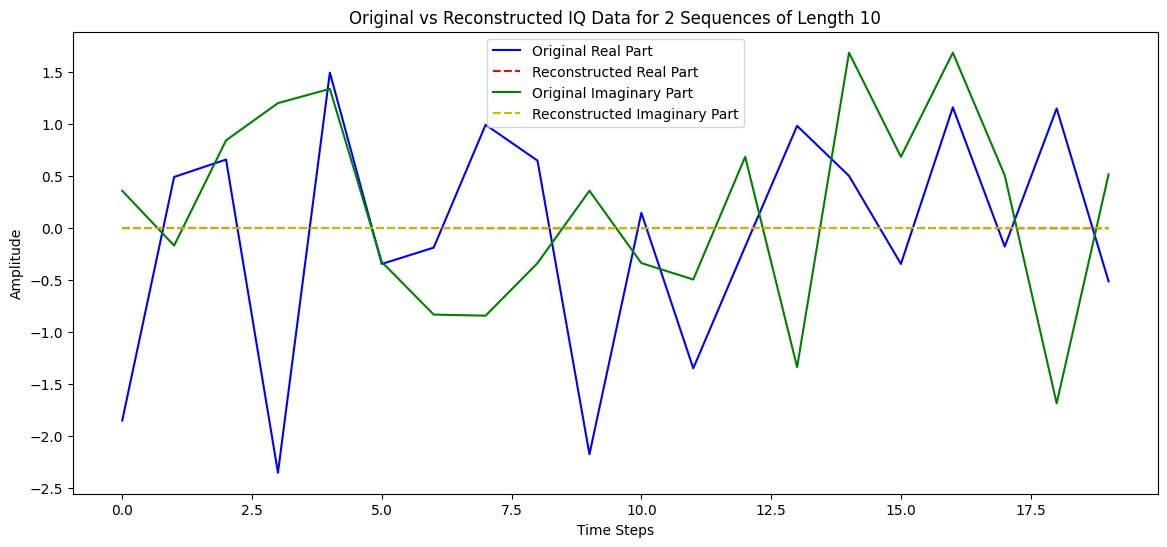

In [3]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

z_mean.shape: (40, 25)
z_log_var.shape: (40, 25)
r before update: tf.Tensor(0.3126834947385624, shape=(), dtype=float64)
M before update: tf.Tensor(
[[-5.98954097e-02 -2.92363367e-05  1.57156811e-01  1.34578844e-02
  -1.56953714e-01  8.31298951e-02  2.10595241e-01  1.71220924e-01
   3.10568348e-02  3.12683495e-01  1.06682579e-02 -7.93095501e-02
   1.99645056e-02 -4.81864409e-02 -5.97186022e-02  1.50419550e-01
   1.30704203e-01 -4.29053717e-02 -1.38248515e-01  6.02005217e-02
   1.30131456e-01  1.07426806e-01  3.79131979e-02 -8.41237009e-02
   4.26409581e-02]
 [ 2.95426444e-01 -9.89220127e-02  2.69896165e-01 -2.32743396e-01
   3.87891738e-01 -1.13890907e-01  3.74074300e-02  2.41549560e-02
   3.29000597e-02  1.14255235e-01  2.31166249e-01  5.11093189e-02
   2.38384258e-01  2.52528642e-01  1.03384028e-01  4.68543460e-01
  -3.97919074e-01  4.32449307e-02 -1.81197221e-02 -8.60748075e-03
   1.64794081e-02 -1.57861975e-01  9.30756458e-02 -2.70747837e-01
  -3.61035564e-01]], shape=(2, 25), dtyp

r after update: tf.Tensor(0.0, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-0.06093728 -0.00826574 -0.01700213 -0.00559271 -0.15888963 -0.02392105
  -0.10500723 -0.03646478 -0.00589245 -0.00266637 -0.00199206 -0.08220664
  -0.01496007 -0.04864277 -0.06211123 -0.00402993 -0.02004929 -0.04529679
  -0.14237368 -0.02755819 -0.00309368 -0.02229441 -0.00180052 -0.08414258
  -0.0154521 ]
 [-0.06320682  0.10155923  0.00604721  0.10147427 -0.37592217  0.0382328
   0.10345481 -0.23534644  0.09168265 -0.42883095  0.103975    0.08331685
   0.10915037  0.10186012  0.07671472 -0.20429348  0.10645391  0.11139028
  -0.04903773 -0.13918527 -0.01253053 -0.4203957   0.10038708 -0.36304465
   0.05545108]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.00266637 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

r after update: tf.Tensor(0.005985391756850711, shape=(), dtype=float64)
M after update: tf.Tensor(
[[-5.98339102e-02 -3.86233197e-03 -1.94248024e-02 -4.09741733e-03
  -1.58912271e-01 -2.31376835e-02 -1.04433325e-01 -3.53894410e-02
  -5.54747334e-03  0.00000000e+00 -3.12250084e-03 -8.36405357e-02
  -1.85358437e-02 -4.83855821e-02 -6.28709112e-02 -3.02333008e-03
  -2.04181829e-02 -4.51179866e-02 -1.44657660e-01 -3.31784592e-02
  -3.83144471e-03 -1.88892239e-02 -1.22555858e-02 -8.29885439e-02
  -1.79443896e-04]
 [-1.35712212e-01  5.91139616e-01  1.42064114e-01 -1.77551917e+00
  -7.91975064e-01  2.46209375e-01  7.35317675e-01 -1.79180441e+00
   5.46887294e-01  3.68823451e-01 -5.28430580e-01  8.32958545e-01
  -4.80039223e-01  8.36292806e-01 -1.53557781e+00  5.47283441e-01
   8.35507981e-01  8.33045190e-01 -7.24754315e-01  5.89036574e-01
   8.34715964e-01 -1.22521966e+00  6.75118472e-01 -1.05635063e+00
   4.35248692e-01]], shape=(2, 25), dtype=float64)
J after update: tf.Tensor(
[[0.       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



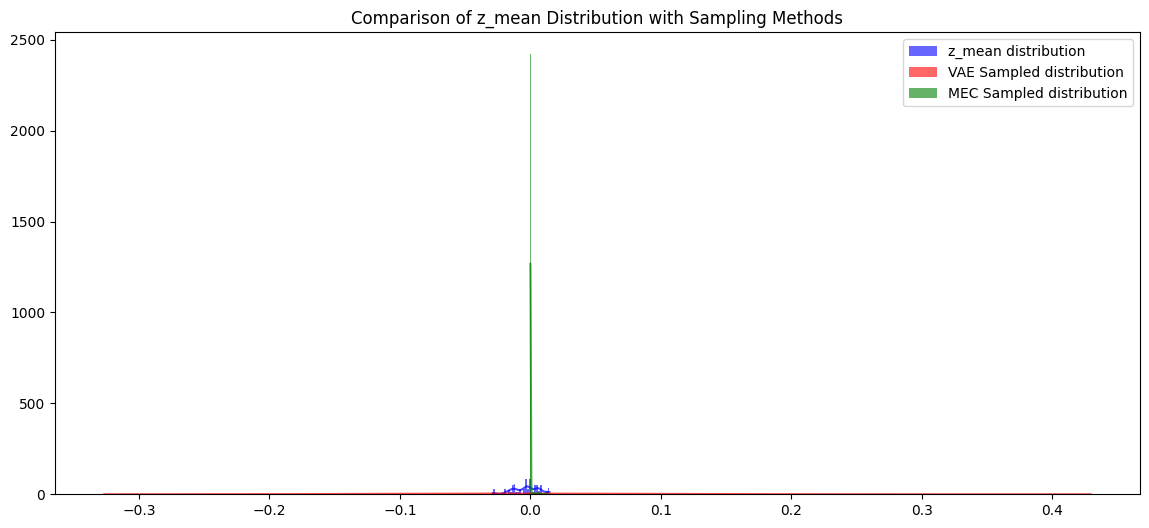

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# Ensure compatibility for TensorFlow 2.x
tf.compat.v1.enable_eager_execution()

# Dummy data assuming z_mean and z_log_var have been obtained
# z_mean = tf.random.normal([100, 50])  # 100 samples, 50 dimensions
# z_log_var = tf.random.normal([100, 50])
print('z_mean.shape:', z_mean.shape)
print('z_log_var.shape:', z_log_var.shape)
z_mean = collected_z_means[0]  # Using only the first batch
z_log_var = collected_z_log_var[0]
z_input = collected_z_inputs[0]

# Simplified version of your model's sampling functions for visualization purposes
def sample_vae(z_mean, z_log_var, epsilon_std=0.1):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

mec_layer = MECTransformationLayer(latent_dim=25)  # Update the latent_dim if needed

def sample_mec(z_mean, z_log_var, z_input):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim), mean=0., stddev=0.1)
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    # Apply the MEC transformation using the instantiated layer
    # Ensure the input is [z_input, z], both must have the same shape
    z_input = z_mean  # For demonstration, using z_mean as z_input, adjust based on your model's specifics
    z_mec = mec_layer([z_input, z])  # The layer expects a list of two tensors
    return z_mec
# Function to plot distributions
def plot_distribution(tensor, label, color):
    #print('tensor:', tensor)
    if isinstance(tensor, tf.Tensor):
        tensor = tensor.numpy()  # Convert TensorFlow tensor to numpy array
    tensor = tensor.flatten()  # Flatten the tensor/array
    
    plt.hist(tensor, bins=30, density=True, alpha=0.6, label=label, color=color)
    
    kde = gaussian_kde(tensor)
    kde_x = np.linspace(tensor.min(), tensor.max(), 500)
    kde_y = kde.evaluate(kde_x)
    plt.plot(kde_x, kde_y, color=color, alpha=0.7)
    
# Generate samples
z_sampled_vae = sample_vae(z_mean, z_log_var)
z_sampled_mec = sample_mec(z_mean, z_log_var, z_input)

# Visualization
# plt.figure(figsize=(14, 6))
# plot_distribution(z_mean.flatten(), "z_mean distribution", "blue")
# plot_distribution(z_input.numpy().flatten(), "z sampled VAE distribution", "red")
# plot_distribution(z_sampled_mec.numpy().flatten(), "z_mec distribution", "green")

# plt.legend()
# plt.title('Latent Variable Distributions Before and After Sampling')
# plt.show()


plt.figure(figsize=(14, 6))
plot_distribution(z_mean.flatten(), "z_mean distribution", "blue")
plot_distribution(z_sampled_vae.numpy().flatten(), "VAE Sampled distribution", "red")
plot_distribution(z_sampled_mec.numpy().flatten(), "MEC Sampled distribution", "green")

plt.legend()
plt.title('Comparison of z_mean Distribution with Sampling Methods')
plt.show()

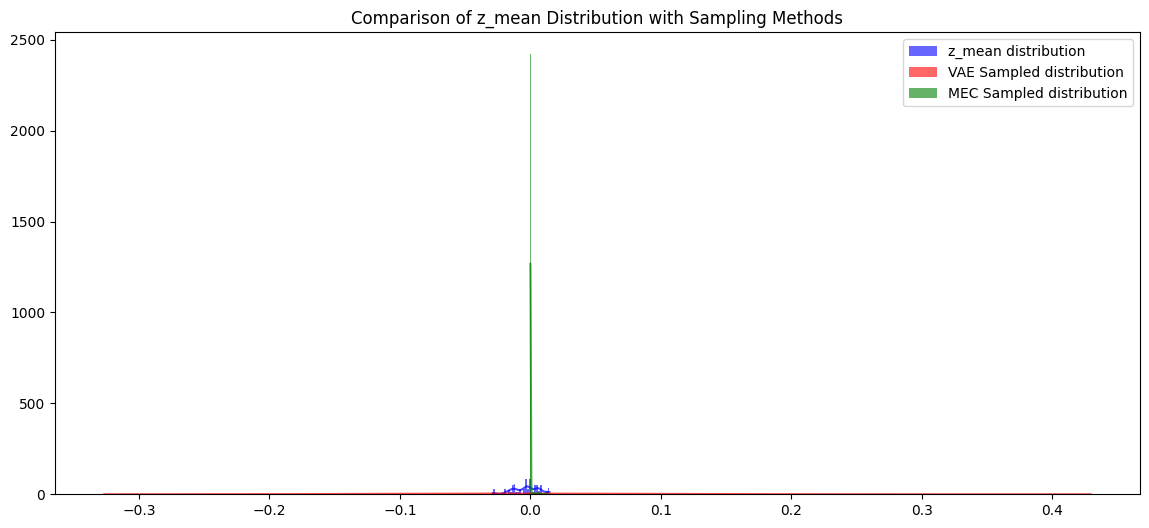

In [8]:
plt.figure(figsize=(14, 6))
plot_distribution(z_mean.flatten(), "z_mean distribution", "blue")
plot_distribution(z_sampled_vae.numpy().flatten(), "VAE Sampled distribution", "red")
plot_distribution(z_sampled_mec.numpy().flatten(), "MEC Sampled distribution", "green")

plt.legend()
plt.title('Comparison of z_mean Distribution with Sampling Methods')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def extract_first_two_dimensions(latent_vars):
    return latent_vars[:, :2]  # Extract first two dimensions and convert to numpy

# Prepare the latent variables
z_mean_2d = extract_first_two_dimensions(z_mean)
z_sampled_vae_2d = extract_first_two_dimensions(z_sampled_vae)
z_sampled_mec_2d = extract_first_two_dimensions(z_sampled_mec)

def scatter_plots(latent_variables, labels, titles):
    # Set up a figure with three subplots
    fig, axs = plt.subplots(3, 1, figsize=(30, 40))
    colors = ['red', 'orange', 'limegreen']

    # First plot: z_mean vs. Sampled VAE
    axs[0].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], color='red', s=50, label='z_mean')
    axs[0].scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], color='orange', s=50, label='Sampled VAE')
    axs[0].set_title(titles[0])
    axs[0].legend()
    axs[0].grid(True)

    # Second plot: z_mean vs. Sampled MEC
    axs[1].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], color='red', s=50, label='z_mean')
    axs[1].scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], color='limegreen', s=50, label='Sampled MEC')
    axs[1].set_title(titles[1])
    axs[1].legend()
    axs[1].grid(True)

    # Third plot: Combined Latent Space
    axs[2].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], color='red', s=50, label='z_mean')
    axs[2].scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], color='orange', s=50, label='Sampled VAE')
    axs[2].scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], color='limegreen', s=50, label='Sampled MEC')
    axs[2].set_title(titles[2])
    axs[2].legend()
    axs[2].grid(True)

    # Set axes labels
    for ax in axs:
        ax.set_xlabel('Latent Dimension 1')
        ax.set_ylabel('Latent Dimension 2')

    plt.tight_layout()
    plt.show()

# Prepare the latent variables for plotting
latent_variables = np.stack([z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d], axis=1)
labels = ['z_mean', 'Sampled VAE', 'Sampled MEC']
titles = ['z_mean vs. Sampled VAE', 'z_mean vs. Sampled MEC', 'Combined Latent Space']

# Call the plotting function
scatter_plots(latent_variables, labels, titles)


In [ ]:
import matplotlib.pyplot as plt

def plot_z_mean_vs_sampled_vae(z_mean_2d, z_sampled_vae_2d):
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], color='red', s=50, label='z_mean')
    plt.scatter(z_sampled_vae_2d[:, 0], z_sampled_vae_2d[:, 1], color='orange', s=50, label='Sampled VAE')
    plt.title('z_mean vs. Sampled VAE')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_z_mean_vs_sampled_vae(z_mean_2d, z_sampled_vae_2d)


In [ ]:
def plot_z_mean_vs_sampled_mec(z_mean_2d, z_sampled_mec_2d):
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], color='red', s=50, label='z_mean')
    plt.scatter(z_sampled_mec_2d[:, 0], z_sampled_mec_2d[:, 1], color='limegreen', s=50, label='Sampled MEC')
    plt.title('z_mean vs. Sampled MEC')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_z_mean_vs_sampled_mec(z_mean_2d, z_sampled_mec_2d)


In [ ]:
def plot_combined_latent_space(z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d):
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean_2d[:, 0], z_mean_2d[:, 1], color='red', s=50, label='z_mean')
    plt.scatter(z_sampled_vae_2d[:, 0], z_sampled_vae_2d[:, 1], color='orange', s=50, label='Sampled VAE')
    plt.scatter(z_sampled_mec_2d[:, 0], z_sampled_mec_2d[:, 1], color='limegreen', s=50, label='Sampled MEC')
    plt.title('Combined Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_combined_latent_space(z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d)


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert TensorFlow tensors to numpy arrays
z_mean_np = z_mean
z_sampled_vae_np = z_sampled_vae.numpy()
z_sampled_mec_np = z_sampled_mec.numpy()

# Only use the first two dimensions for the 2D scatter plot
z_mean_np = z_mean_np[:, :2]
z_sampled_vae_np = z_sampled_vae_np[:, :2]
z_sampled_mec_np = z_sampled_mec_np[:, :2]

# Create a DataFrame
df = pd.DataFrame({
    'Latent Dimension 1': np.concatenate([z_mean_np[:, 0], z_sampled_vae_np[:, 0], z_sampled_mec_np[:, 0]]),
    'Latent Dimension 2': np.concatenate([z_mean_np[:, 1], z_sampled_vae_np[:, 1], z_sampled_mec_np[:, 1]]),
    'Type': ['z_mean'] * len(z_mean_np) + ['z (Sampled VAE)'] * len(z_sampled_vae_np) + ['z_mec (Sampled MEC)'] * len(z_sampled_mec_np)
})

def enhanced_scatter_plot(dataframe, hue, figsize=(12, 9), marker_sizes_dict=None,
                          context='talk', style='whitegrid', palette='colorblind',
                          title='Enhanced Latent Space 2D Distribution with Seaborn',
                          extend_axis_factor=2):
    # Set the aesthetics
    sns.set(style=style, context=context, palette=palette)

    plt.figure(figsize=figsize)
    default_marker_size = 150

    if marker_sizes_dict:
        for category, msize in marker_sizes_dict.items():
            subset = dataframe[dataframe[hue] == category]
            sns.scatterplot(data=subset, x='Latent Dimension 1', y='Latent Dimension 2', 
                            hue=hue, s=msize, alpha=0.8, legend=False)
    else:
        sns.scatterplot(data=dataframe, x='Latent Dimension 1', y='Latent Dimension 2', 
                        hue=hue, s=default_marker_size, alpha=0.8)

    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.xlim(x_min * extend_axis_factor, x_max * extend_axis_factor)
    plt.ylim(y_min * extend_axis_factor, y_max * extend_axis_factor)

    plt.legend(title=hue, title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('Latent Dimension 1', fontsize=15)
    plt.ylabel('Latent Dimension 2', fontsize=15)
    plt.title(title, fontsize=18)
    sns.despine(trim=True)
    plt.show()
    
def enhanced_scatter_plot(dataframe, hue, figsize=(12, 9), marker_sizes_dict=None,
                          context='talk', style='whitegrid', palette=None,
                          title='Enhanced Latent Space 2D Distribution with Seaborn',
                          extend_axis_factor=2):
    # Set the aesthetics
    sns.set(style=style, context=context)

    plt.figure(figsize=figsize)

    # Define the color palette manually if not provided
    if palette is None:
        palette = {
            'z_mean': 'red',
            'z (Sampled VAE)': 'orange',
            'z_mec (Sampled MEC)': 'limegreen'
        }
    
    # Define default marker size if not provided
    if marker_sizes_dict is None:
        marker_sizes_dict = {
            'z_mean': 100,        # Default marker size for z_mean
            'z (Sampled VAE)': 100,   # Default marker size for Sampled VAE
            'z_mec (Sampled MEC)': 150    # Default marker size for Sampled MEC
        }

    # Plot each subset with its specified marker size
    for category, msize in marker_sizes_dict.items():
        subset = dataframe[dataframe[hue] == category]
        sns.scatterplot(data=subset, x='Latent Dimension 1', y='Latent Dimension 2',
                        hue=hue, palette=palette, s=msize, alpha=0.8, legend=False)
    
    # Plot the legend separately
    for category in marker_sizes_dict.keys():
        plt.scatter([], [], color=palette[category], s=marker_sizes_dict[category],
                    label=category, alpha=0.8)
    
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    plt.xlim(x_min * extend_axis_factor, x_max * extend_axis_factor)
    plt.ylim(y_min * extend_axis_factor, y_max * extend_axis_factor)

    plt.legend(title=hue, title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('Latent Dimension 1', fontsize=15)
    plt.ylabel('Latent Dimension 2', fontsize=15)
    plt.title(title, fontsize=18)
    sns.despine(trim=True)
    plt.show()

# Call the function with custom settings
enhanced_scatter_plot(df, hue='Type', extend_axis_factor=2)




# # Define a custom color palette and marker sizes
# custom_colors = ["#9b59b6", "#3498db", "#95a5a6"]  # purple, blue, grey
# custom_marker_sizes = {
#     'z_mean': 200,
#     'Sampled VAE': 150,
#     'Sampled MEC': 100
# }

# # Call the function with custom settings
# enhanced_scatter_plot(df, hue='Type', palette=custom_colors, marker_sizes_dict=custom_marker_sizes, extend_axis_factor=2)


In [ ]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

In [ ]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


In [ ]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


In [ ]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()

In [ ]:
#Time Series Plot of IQ Samples:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('5-Original vs Reconstructed IQ Data.png')
# plt.close()
plt.show()


In [ ]:
#Scatter Plot of Reconstruction Errors vs. Real and Imaginary Parts:
avg_real = np.mean(X_chunk_test, axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test, axis=1)[:, 1]

last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", len(last_errors))


plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('6-Reconstruction Error vs. Average Real Part.png')
# plt.close()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('7-Reconstruction Error vs. Average Imaginary Part.png')
# plt.close()
plt.show()

In [ ]:
# # Define the number of sequences to plot together
n = 8  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Img Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Img Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# # Define the number of sequences to plot together
n = 9  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Repeat for n = 9
n = 2  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')

plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Repeat for n = 9
n = 1  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()

In [ ]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()